In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

from tqdm import tqdm

In [2]:
methods = ["superspike", "stochasticsuperspike"]
times = ["08-42-20", "08-50-54"]
dataset = "oxford"

nb_epochs = 1500
logging_freq = 500

epochs = [499, 999, 1499]

dt = 1e-3
data_id = 0
seeds = [17]
n_trials = 1

In [3]:
path = "../experiments/Runs/{}/dataset=oxford/2024-04-24/{}/data"

colors = {
    "stochasticsuperspike": "#EBB400",
    "superspike": "#008ca5"
}
names = {
    "stochasticsuperspike": "stochastic",
    "superspike": "deterministic"
}

data_path = "../experiments/dataset/{}.png".format(dataset)

In [4]:
spk_0 = {}
spk_end = {}

for method, time in zip(methods, times):
    spk_0[method] = np.load(os.path.join(path.format(method, time), "spk_hist_h_{}.npy".format(logging_freq-1)))
    spk_end[method] = np.load(
        os.path.join(path.format(method, time),
                     "spk_hist_h_{}.npy".format(nb_epochs - 1))
    )


In [5]:
def get_isi(spk):
    # compute inter-spike intervals of a spike train
    spk_times = np.where(spk)[0]
    isi = []
    if len(spk_times) > 2:
        for i in range(len(spk_times) - 1):
            isi.append(spk_times[i + 1] - spk_times[i])
    return np.array(isi)


In [6]:
# get hidden layer representation of last epoch
def get_isi_and_fr(spk, methods, seeds, n_trials, dt):
    isi_per_neurons = {}
    fr_per_neurons = {}
    duration = spk["superspike"].shape[-2] * dt

    for method in methods:
        isi_per_neurons[method] = []
        fr_per_neurons[method] = []

        for neuron in range(spk[method].shape[-1]):
            isi_neuron = []
            fr_neuron = []
            for seed_idx in range(len(seeds)):
                if method == "superspike":
                    trials = 1
                else:
                    trials = n_trials
                for trial_idx in range(trials):
                    isi_neuron += list(
                        get_isi(spk[method][seed_idx, trial_idx, 0, :, neuron])
                    )
                    fr_neuron.append(
                        np.sum(spk[method][seed_idx, trial_idx, 0, :, neuron])
                        / duration
                    )
            isi_per_neurons[method].append(isi_neuron)
            fr_per_neurons[method].append(fr_neuron)
    return isi_per_neurons, fr_per_neurons


## before training

  0%|          | 0/2 [00:00<?, ?it/s]/home/gygajuli/miniconda3/envs/stoch/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gygajuli/miniconda3/envs/stoch/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/gygajuli/miniconda3/envs/stoch/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gygajuli/miniconda3/envs/stoch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gygajuli/miniconda3/envs/stoch/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / r

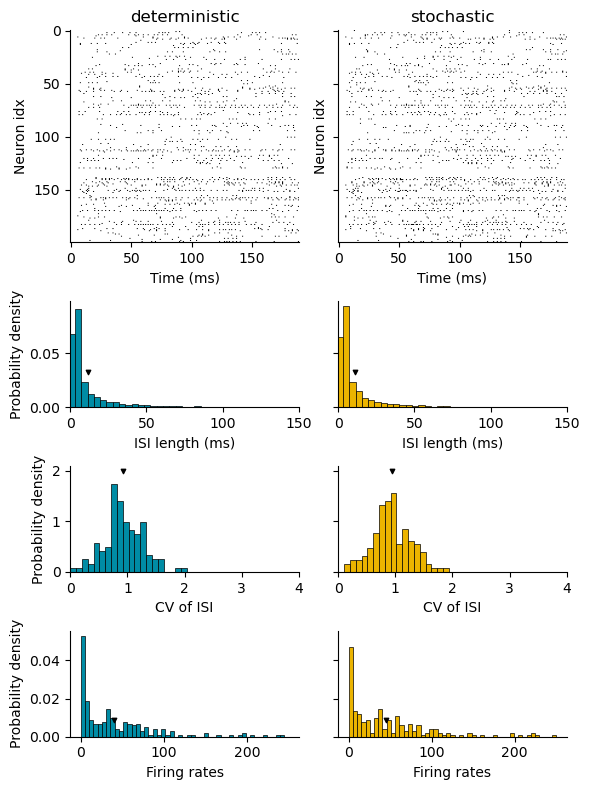

In [7]:
isi_per_neurons, fr_per_neurons = get_isi_and_fr(
    spk_0, methods, seeds, n_trials, dt)

fig, axs = plt.subplots(
    4,
    2,
    figsize=(6, 8),
    dpi=100,
    sharex="row",
    sharey="row",
    gridspec_kw={"height_ratios": [2, 1, 1, 1]},
)

ax = axs[1]
ax2 = axs[2]
ax3 = axs[3]
ax4 = axs[0]

i_idxs = [0.033, 0.033, 0.033]
p_idxs = [2, 2, 1.6]
v_idxs = [0.009, 0.009, 0.01]

n_seeds = len(seeds)
for i, method in enumerate(tqdm(methods)):
    all_isi = []
    all_fr = []
    cv_isi = []
    for neuron_idx in range(spk_0[method].shape[-1]):
        all_isi += isi_per_neurons[method][neuron_idx]
        all_fr += fr_per_neurons[method][neuron_idx]
        cv_isi.append(
            np.std(isi_per_neurons[method][neuron_idx])
            / np.mean(isi_per_neurons[method][neuron_idx])
        )

    axs[0][i].set_title(names[method])

    ax[i].hist(
        all_isi,
        bins=np.linspace(-1, 201, 50),
        density=True,
        color=colors[method],
        alpha=1,
        edgecolor="black",
        linewidth=0.5,
    )
    ax[i].set_xlabel("ISI length (ms)")

    ax[i].scatter(np.mean(all_isi), i_idxs[i], color="black", marker="v", s=10)
    ax[i].set_xlim(0, 150)

    ax2[i].hist(
        cv_isi,
        bins=np.linspace(0, 5, 50),
        density=True,
        color=colors[method],
        alpha=1,
        edgecolor="black",
        linewidth=0.5,
    )
    ax2[i].set_xlabel("CV of ISI")

    ax2[i].scatter(np.nanmean(cv_isi), p_idxs[i],
                   color="black", marker="v", s=10)
    ax2[i].set_xlim(0, 4)

    ax3[i].hist(
        all_fr,
        bins=np.linspace(0, 250, 50),
        density=True,
        color=colors[method],
        alpha=1,
        edgecolor="black",
        linewidth=0.5,
    )
    ax3[i].scatter(np.nanmean(all_fr), v_idxs[i],
                   color="black", marker="v", s=10)
    ax3[i].set_xlabel("Firing rates")

    ax4[i].imshow(
        spk_0[method][0, 0, 0, :, :].T, aspect="auto", cmap="Greys", vmin=0, vmax=1
    )
    ax4[i].set_xlabel("Time (ms)")
    ax4[i].set_ylabel("Neuron idx")


sns.despine()

ax[0].set_ylabel("Probability density")
ax2[0].set_ylabel("Probability density")
ax3[0].set_ylabel("Probability density")

plt.tight_layout()


## After training

100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


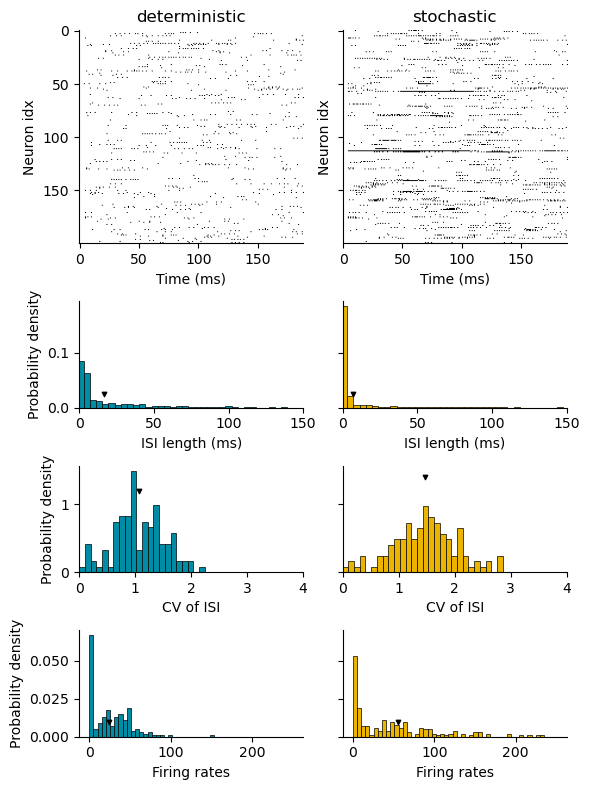

In [8]:
isi_per_neurons, fr_per_neurons = get_isi_and_fr(
    spk_end, methods, seeds, n_trials, dt)

fig, axs = plt.subplots(
    4,
    2,
    figsize=(6, 8),
    dpi=100,
    sharex="row",
    sharey="row",
    gridspec_kw={"height_ratios": [2, 1, 1, 1]},
)

ax = axs[1]
ax2 = axs[2]
ax3 = axs[3]
ax4 = axs[0]

i_idxs = [0.025, 0.025, 0.02]
p_idxs = [1.2, 1.4, 1.3]
v_idxs = [0.01, 0.01, 0.018]

n_seeds = len(seeds)
for i, method in enumerate(tqdm(methods)):
    all_isi = []
    all_fr = []
    cv_isi = []
    for neuron_idx in range(spk_end[method].shape[-1]):
        all_isi += isi_per_neurons[method][neuron_idx]
        all_fr += fr_per_neurons[method][neuron_idx]
        cv_isi.append(
            np.std(isi_per_neurons[method][neuron_idx])
            / np.mean(isi_per_neurons[method][neuron_idx])
        )

    axs[0][i].set_title(names[method])

    ax[i].hist(
        all_isi,
        bins=np.linspace(-1, 201, 50),
        density=True,
        color=colors[method],
        alpha=1,
        edgecolor="black",
        linewidth=0.5,
    )
    ax[i].set_xlabel("ISI length (ms)")

    ax[i].scatter(np.mean(all_isi), i_idxs[i], color="black", marker="v", s=10)
    ax[i].set_xlim(0, 150)

    ax2[i].hist(
        cv_isi,
        bins=np.linspace(0, 5, 50),
        density=True,
        color=colors[method],
        alpha=1,
        edgecolor="black",
        linewidth=0.5,
    )
    ax2[i].set_xlabel("CV of ISI")

    ax2[i].scatter(np.nanmean(cv_isi), p_idxs[i],
                   color="black", marker="v", s=10)
    ax2[i].set_xlim(0, 4)

    ax3[i].hist(
        all_fr,
        bins=np.linspace(0, 250, 50),
        density=True,
        color=colors[method],
        alpha=1,
        edgecolor="black",
        linewidth=0.5,
    )
    ax3[i].scatter(np.nanmean(all_fr), v_idxs[i],
                   color="black", marker="v", s=10)
    ax3[i].set_xlabel("Firing rates")

    ax4[i].imshow(
        spk_end[method][0, 0, 0, :, :].T, aspect="auto", cmap="Greys", vmin=0, vmax=1
    )
    ax4[i].set_xlabel("Time (ms)")
    ax4[i].set_ylabel("Neuron idx")


sns.despine()

ax[0].set_ylabel("Probability density")
ax2[0].set_ylabel("Probability density")
ax3[0].set_ylabel("Probability density")

plt.tight_layout()
